In [1]:
import pandas as pd
import altair as alt
from altair import datum
alt.renderers.enable('notebook')
import numpy as np
import seaborn as sns
alt.data_transformers.enable('default', max_rows=None)
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("googleplaystore.csv")
df = data
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)


df['Size'] = df['Size'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: float(x))

df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

In [3]:
df['Category'] = df['Category'].apply(lambda x: x.lower().replace("_", " "))

In [4]:
mean_rating = df['Rating'].median()

In [414]:
base = alt.Chart(df, height=600, width=400)
labels = list(df.groupby("Category").sum().sort_values('Installs', ascending=False).index)
# Define aggregate fields
lower_box = 'q1(Rating):Q'
lower_whisker = 'min(Rating):Q'
upper_box = 'q3(Rating):Q'
upper_whisker = 'max(Rating):Q'
# Compose each layer individually
lower_plot = base.mark_rule(opacity=0.2).encode(
    x=alt.X(lower_whisker, axis=alt.Axis(title="")),
    x2=lower_box,
    y=alt.Y('Category:O', sort=labels, axis=alt.Axis(labels=False, ticks=False, title=None))
)
middle_plot = base.mark_bar(size=10, strokeWidth=0.8, stroke='black', strokeOpacity=0.4).encode(
    x=alt.X(lower_box, scale=alt.Scale(zero=False, domain=[5, 1]), axis=alt.Axis(domain=True)),
    x2=upper_box,
    y=alt.Y('Category:O', sort=labels, axis=alt.Axis(labels=False, ticks=False, title=None)),
    fill=alt.Color('sum(Installs)', legend=None,
                   scale=alt.Scale(range=["white", "lightpink", "lightpink"]))
)
upper_plot = base.mark_rule(opacity=0.2).encode(
    x=upper_whisker,
    x2=upper_box,
    y=alt.Y('Category:O', sort=labels, axis=alt.Axis(labels=False, ticks=False, title=""))
)

middle_tick = base.mark_tick(
    color='black',
    size=10.0
).encode(
    x=alt.X('median(Rating):Q', axis=alt.Axis(orient='top', format="f")),
    y=alt.Y('Category:O', sort=labels, axis=alt.Axis(orient='right', title=""))
)
mean_line = base.mark_rule(color='blue', size=2, opacity=0.5).encode(x="median(Rating)")
plot_one = (middle_plot + lower_plot + upper_plot + middle_tick + mean_line)\
.configure_axis(titleFont='Interstate', labelFont='Futura').resolve_scale(y='independent')

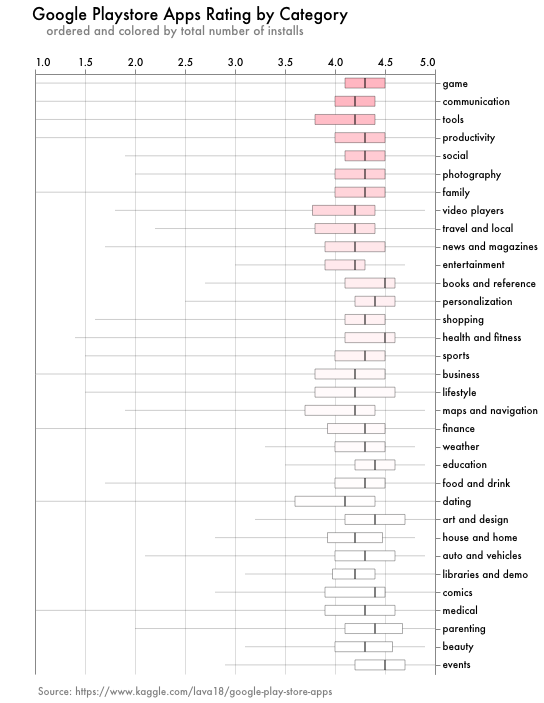

In [415]:
plot_one + alt.Chart(pd.DataFrame({'text': ["Google Playstore Apps Rating by Category"]}))\
    .mark_text(dx=-45, dy=-65, size=16, font='Futura')\
    .encode(text="text") +\
alt.Chart(pd.DataFrame({'text': ["ordered and colored by total number of installs"]}))\
    .mark_text(dx=-60, dy=-50, size=12, font='Futura', opacity=0.5)\
    .encode(text="text")+\
alt.Chart(pd.DataFrame({'text': ["Source: https://www.kaggle.com/lava18/google-play-store-apps"]}))\
    .mark_text(dx=-50, dy=610, size=10, font='Futura', opacity=0.5)\
    .encode(text="text")

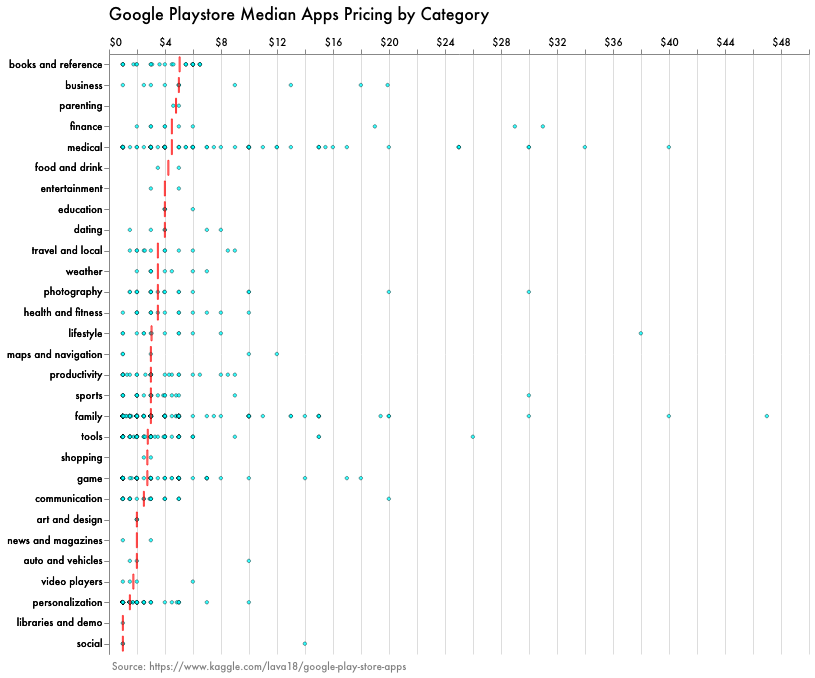

In [416]:
base = alt.Chart(df, height=600, width=700)
((base.mark_point(color='black', fill='cyan', stroke='black', strokeWidth=0.5, opacity=0.8, size=12, strokeOpacity=1).encode(
    y=alt.Y('Category:O', axis=alt.Axis(orient='left', minExtent=0, labelOverlap=False, title=""),
           sort=alt.EncodingSortField(field='Price', op='median', order="descending")),
    x=alt.X('Price:Q', axis=alt.Axis(orient='top', title="", format="$")),
#     opacity=alt.Opacity('Size', sort="descending")
).transform_filter((datum.Price < 50) & (datum.Price > 0)) +\
base.mark_tick(color='black', stroke='red', strokeWidth=0.8, strokeOpacity=1, size=15).encode(
    y=alt.Y('Category:O', axis=alt.Axis(orient='left', minExtent=0, labelOverlap=False, title=""),
           sort=alt.EncodingSortField(field='Price', op='median', order="descending")),
    x=alt.X('median(Price):Q', axis=alt.Axis(orient='top', title="", format="$"))
).transform_filter((datum.Price < 50) & (datum.Price > 0)))\
.resolve_scale(y='independent') +\
alt.Chart(pd.DataFrame({'text': ["Google Playstore Median Apps Pricing by Category"]}))\
    .mark_text(dx=-160, dy=-45, size=16, font='Futura')\
    .encode(text="text") +\
alt.Chart(pd.DataFrame({'text': ["Source: https://www.kaggle.com/lava18/google-play-store-apps"]}))\
    .mark_text(dx=-200, dy=605, size=10, font='Futura', opacity=0.5)\
    .encode(text="text"))\
.configure_axis(titleFont='Interstate', labelFont='Futura')\


In [440]:
reviews = pd.read_csv("googleplaystore_user_reviews.csv")

In [441]:
reviews = reviews.merge(df, on='App')

In [442]:
revdf = reviews.groupby(['Category', 'Sentiment', 'Type'])[['App']].count().reset_index()

In [443]:
revdf = revdf.groupby('Category')[['App']]\
    .sum()\
    .rename(columns={"App": "Total"})\
    .merge(revdf, on='Category')\
    .assign(fraction=lambda x: x['App']/x['Total'])

In [444]:
labels = list(revdf[revdf.Sentiment=='Positive'].groupby("Category").sum().sort_values('fraction', ascending=True).index)

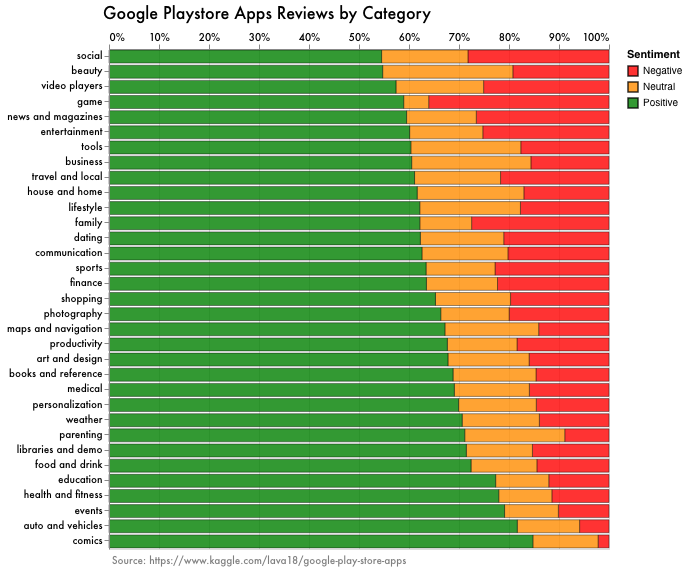

In [481]:
(alt.Chart(revdf, height=500, width=500)\
.mark_bar(opacity=0.80, size=13, strokeWidth=0.5, stroke='black').encode(
    y=alt.Y('Category:O', axis=alt.Axis(orient='left', minExtent=0, labelOverlap=False, title=""), sort=labels),
    x=alt.X('sum(fraction)', axis=alt.Axis(orient='top', title="", format=".0%")),
    color=alt.Color('Sentiment', scale=alt.Scale(range=['red', 'darkorange', 'green']))
)+\
alt.Chart(pd.DataFrame({'text': ["Google Playstore Apps Reviews by Category"]}))\
    .mark_text(dx=-92, dy=-280, size=16, font='Futura')\
    .encode(text="text") +\
alt.Chart(pd.DataFrame({'text': ["Source: https://www.kaggle.com/lava18/google-play-store-apps"]}))\
    .mark_text(dx=-100, dy=265, size=10, font='Futura', opacity=0.5)\
    .encode(text="text")).configure_axis(titleFont='Interstate', labelFont='Futura')